# Лабораторная работа 1. Визуализация и предварительная обработка данных

### Жунёв Андрей Александрович РИМ-150950

# I. ВВЕДЕНИЕ

## 1.1 Описание задачи

**Тип задачи:** Регрессия  
**Целевая переменная:** Financial Loss (in Million $) - финансовый ущерб от кибератаки  
**Бизнес-контекст:** Оценка ущерба позволяет бизнесу лучше спланировать защитные меры, определить бюджеты безопасности.

## 1.2 Описание датасета

**Источник данных:** Kaggle  
**Датасет:** Global Cybersecurity Threats (2015-2024)  
**Размерность:** ~3000 записей, 10 признаков  
**Ссылка:** https://www.kaggle.com/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024

# II. ПОДГОТОВКА РАБОЧЕЙ СРЕДЫ

## 2.1 Импорт библиотек

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

## 2.2 Загрузка данных

In [2]:
path = 'data/global-cybersecurity-threats/GCT_20152024.csv'
df = pd.read_csv(path, delimiter=',')

print(f"Размерность: {df.shape}")
df.head()

Размерность: (3000, 10)


,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


# III. РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)

## 3.1 Первичный осмотр данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mechanism Used               3000 non-null   object 
 9   Incident Resolution Time (in Hours)  3000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 234.5+ KB


In [4]:
print("Пропуски:", df.isnull().sum().sum())
print("Дубликаты:", df.duplicated().sum())

Пропуски: 0
Дубликаты: 0


In [5]:
cat_columns = [col for col in df.columns if df[col].dtype == 'object']
num_columns = [col for col in df.columns if df[col].dtype != 'object']

print(f"Категориальные ({len(cat_columns)}): {cat_columns}")
print(f"Числовые ({len(num_columns)}): {num_columns}")

Категориальные (6): ['Country', 'Attack Type', 'Target Industry', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used']
Числовые (4): ['Year', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']


## 3.2 Анализ дубликатов

In [6]:
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Удалено {duplicates} дубликатов")
else:
    print("Дубликаты не обнаружены")

Дубликаты не обнаружены


## 3.3 Анализ числовых признаков

In [ ]:
### 3.3.1 Описательная статистика

,Year,Financial Loss (in Million $),Number of Affected Users,Incident Resolution Time (in Hours)
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2019.570333,50.492970,504684.136333,36.476000
std,2.857932,28.791415,289944.084972,20.570768
min,2015.000000,0.500000,424.000000,1.000000
25%,2017.000000,25.757500,255805.250000,19.000000
50%,2020.000000,50.795000,504513.000000,37.000000
75%,2022.000000,75.630000,758088.500000,55.000000
max,2024.000000,99.990000,999635.000000,72.000000


In [ ]:
df.describe()


### 3.3.2 Распределение числовых признаков в обычной шкале

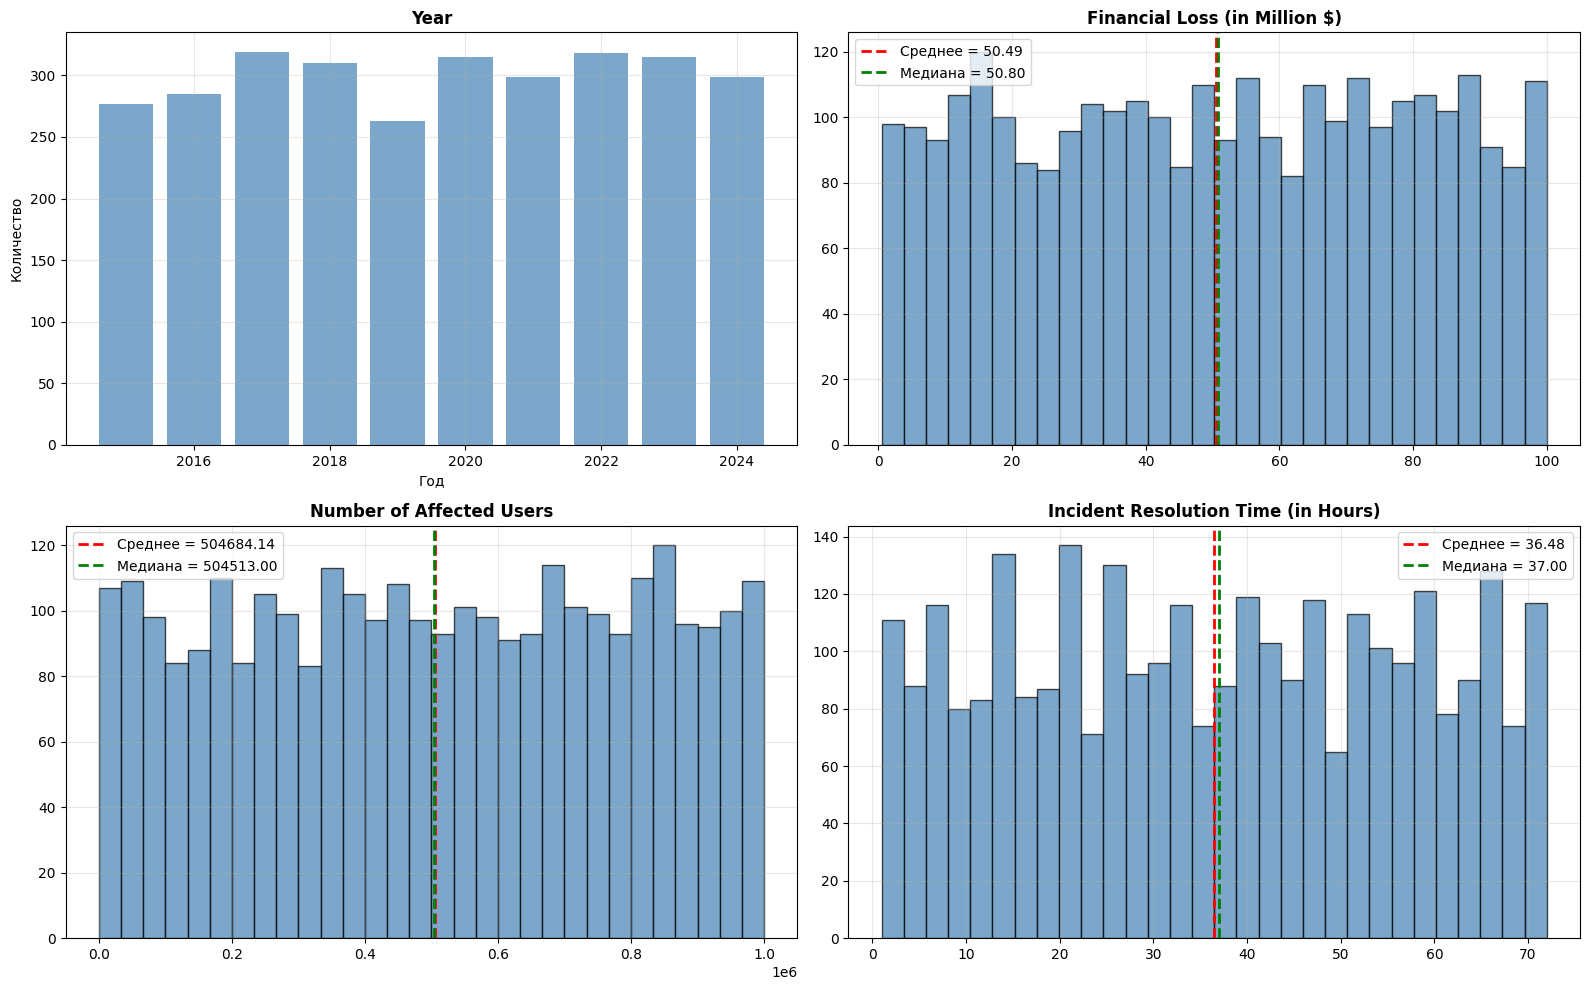

In [30]:
# Гистограммы всех числовых признаков в обычной шкале
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(num_columns):
    # Исключаем Year из обычного анализа (он имеет равномерное распределение по годам)
    if col == 'Year':
        # Для Year - столбчатая диаграмма
        year_counts = df['Year'].value_counts().sort_index()
        axes[idx].bar(year_counts.index, year_counts.values, color='steelblue', alpha=0.7)
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Год')
        axes[idx].set_ylabel('Количество')
    else:
        # Для остальных - гистограммы с линиями среднего и медианы
        axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        axes[idx].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Среднее = {df[col].mean():.2f}')
        axes[idx].axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label=f'Медиана = {df[col].median():.2f}')
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].legend()
    
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.3.3 Распределение в логарифмической шкале (для целевых признаков)


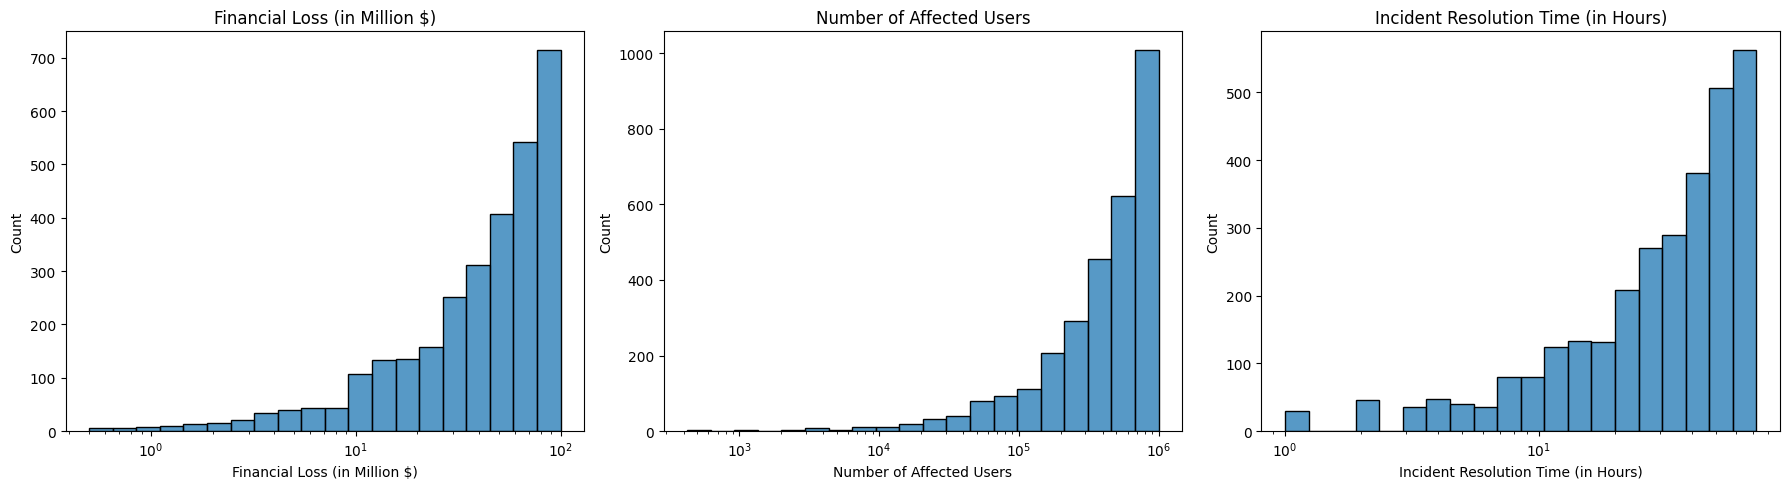

In [ ]:
# Гистограммы в логарифмической шкале для каждого числового признака (кроме Year)
cols_to_log = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(cols_to_log):
    log_values = np.log10(df[col])
    axes[idx].hist(log_values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(log_values.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Среднее (log10) = {log_values.mean():.3f}')
    axes[idx].axvline(log_values.median(), color='green', linestyle='--', linewidth=2, 
                      label=f'Медиана (log10) = {log_values.median():.3f}')
    axes[idx].set_xlabel(f'log10({col})')
    axes[idx].set_ylabel('Частота')
    axes[idx].set_title(col, fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.3.4 Детальный анализ финансовых потерь


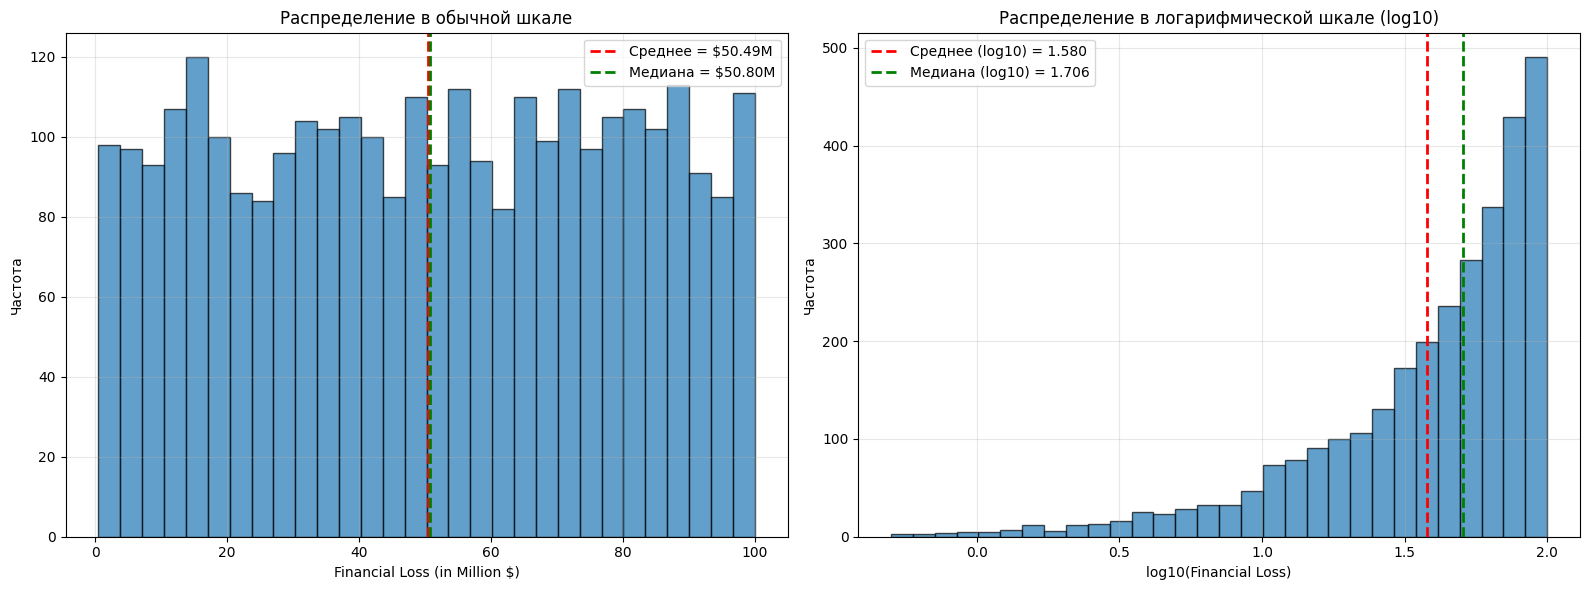

In [ ]:
# Детальное сравнение: обычная vs логарифмическая шкала для целевой переменной
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

col = 'Financial Loss (in Million $)'
log_col = np.log10(df[col])

# 1. Гистограмма обычная шкала
axes[0, 0].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Среднее = ${df[col].mean():.2f}M')
axes[0, 0].axvline(df[col].median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Медиана = ${df[col].median():.2f}M')
axes[0, 0].set_xlabel('Financial Loss (Million $)')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].set_title('Распределение в обычной шкале', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Гистограмма логарифмическая шкала
axes[0, 1].hist(log_col, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(log_col.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Среднее (log10) = {log_col.mean():.3f}')
axes[0, 1].axvline(log_col.median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Медиана (log10) = {log_col.median():.3f}')
axes[0, 1].set_xlabel('log10(Financial Loss)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение в логарифмической шкале', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. QQ-plot логарифмической шкалы
mu = log_col.mean()
sigma = log_col.std()
x = np.linspace(log_col.min(), log_col.max(), 100)
axes[1, 0].hist(log_col, bins=30, density=True, alpha=0.7, color='steelblue', label='Эмпирическое')
axes[1, 0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Теоретическое нормальное')
axes[1, 0].set_xlabel('log10(Financial Loss)')
axes[1, 0].set_ylabel('Плотность вероятности')
axes[1, 0].set_title('Сравнение с нормальным распределением', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot логарифмической шкалы
axes[1, 1].boxplot(log_col, vert=True)
axes[1, 1].set_ylabel('log10(Financial Loss)')
axes[1, 1].set_title('Box plot (выявление выбросов)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.3.5 Детальный анализ: Number of Affected Users


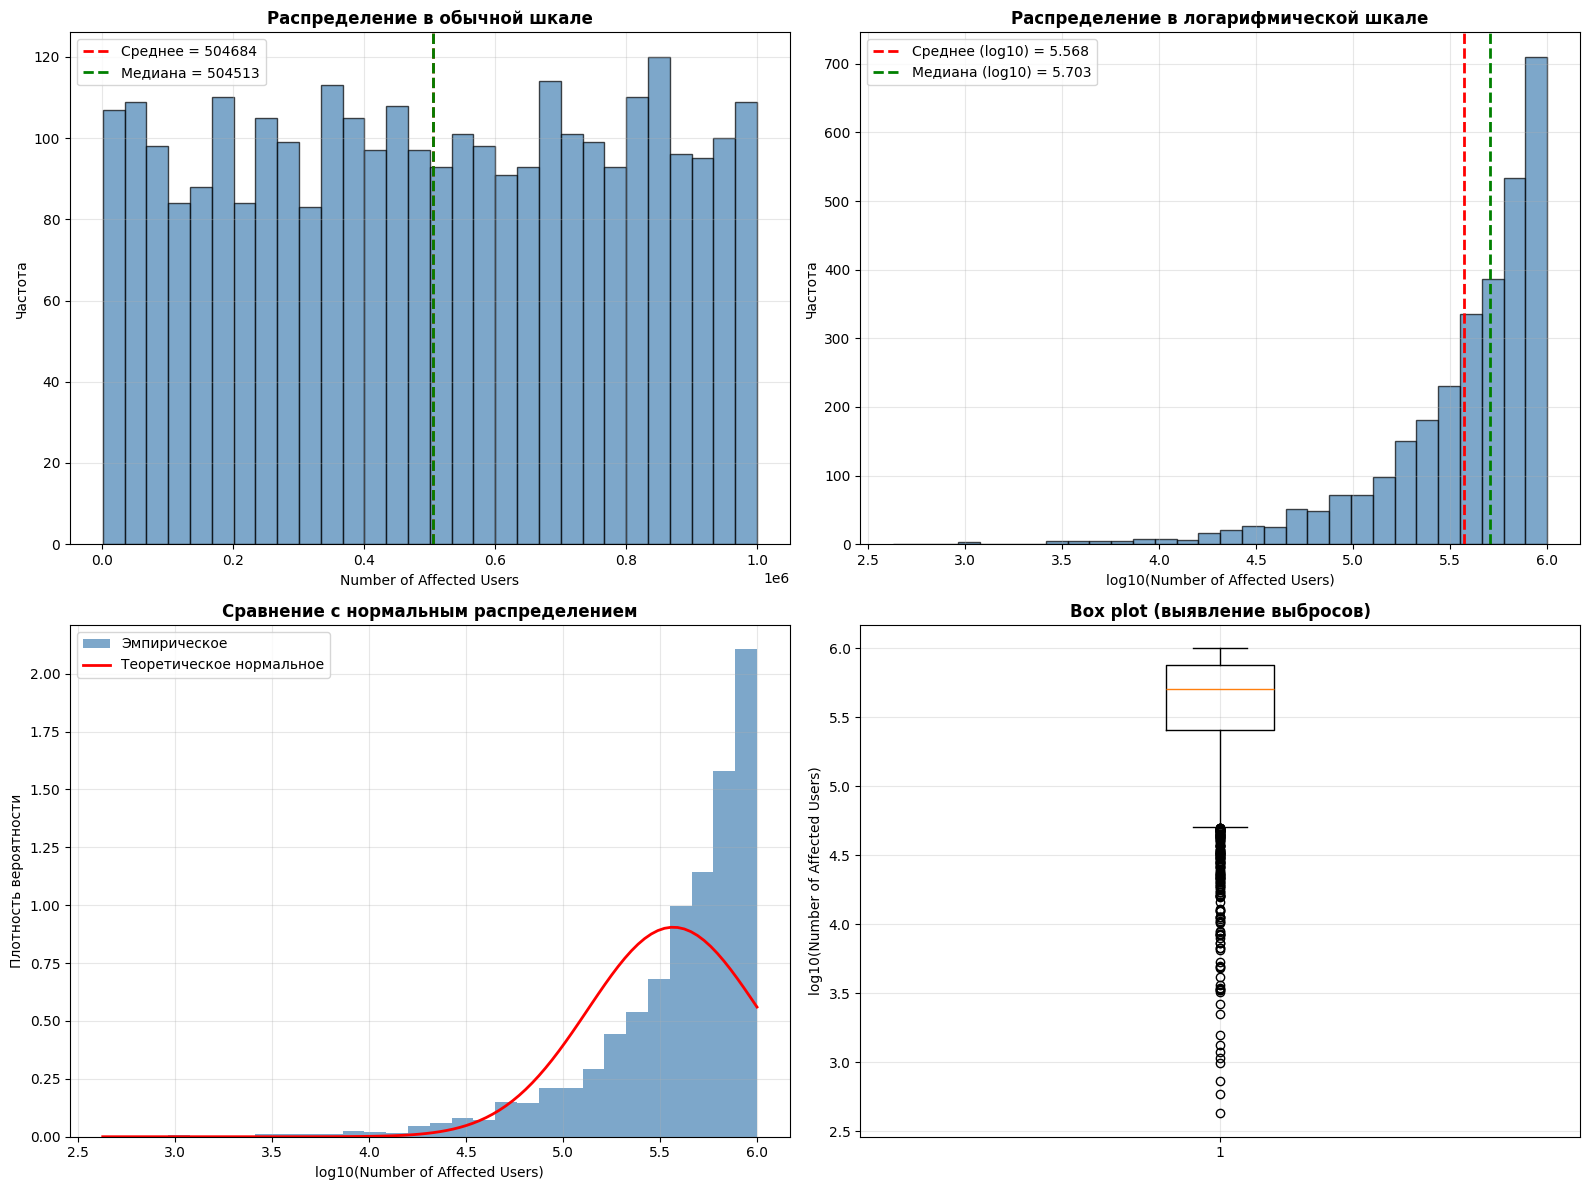

In [31]:
# Детальное сравнение для Number of Affected Users
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

col = 'Number of Affected Users'
log_col = np.log10(df[col])

# 1. Гистограмма обычная шкала
axes[0, 0].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Среднее = {df[col].mean():.0f}')
axes[0, 0].axvline(df[col].median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Медиана = {df[col].median():.0f}')
axes[0, 0].set_xlabel('Number of Affected Users')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].set_title('Распределение в обычной шкале', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Гистограмма логарифмическая шкала
axes[0, 1].hist(log_col, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(log_col.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Среднее (log10) = {log_col.mean():.3f}')
axes[0, 1].axvline(log_col.median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Медиана (log10) = {log_col.median():.3f}')
axes[0, 1].set_xlabel('log10(Number of Affected Users)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение в логарифмической шкале', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. QQ-plot логарифмической шкалы
mu = log_col.mean()
sigma = log_col.std()
x = np.linspace(log_col.min(), log_col.max(), 100)
axes[1, 0].hist(log_col, bins=30, density=True, alpha=0.7, color='steelblue', label='Эмпирическое')
axes[1, 0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Теоретическое нормальное')
axes[1, 0].set_xlabel('log10(Number of Affected Users)')
axes[1, 0].set_ylabel('Плотность вероятности')
axes[1, 0].set_title('Сравнение с нормальным распределением', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot логарифмической шкалы
axes[1, 1].boxplot(log_col, vert=True)
axes[1, 1].set_ylabel('log10(Number of Affected Users)')
axes[1, 1].set_title('Box plot (выявление выбросов)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.3.6 Детальный анализ: Incident Resolution Time


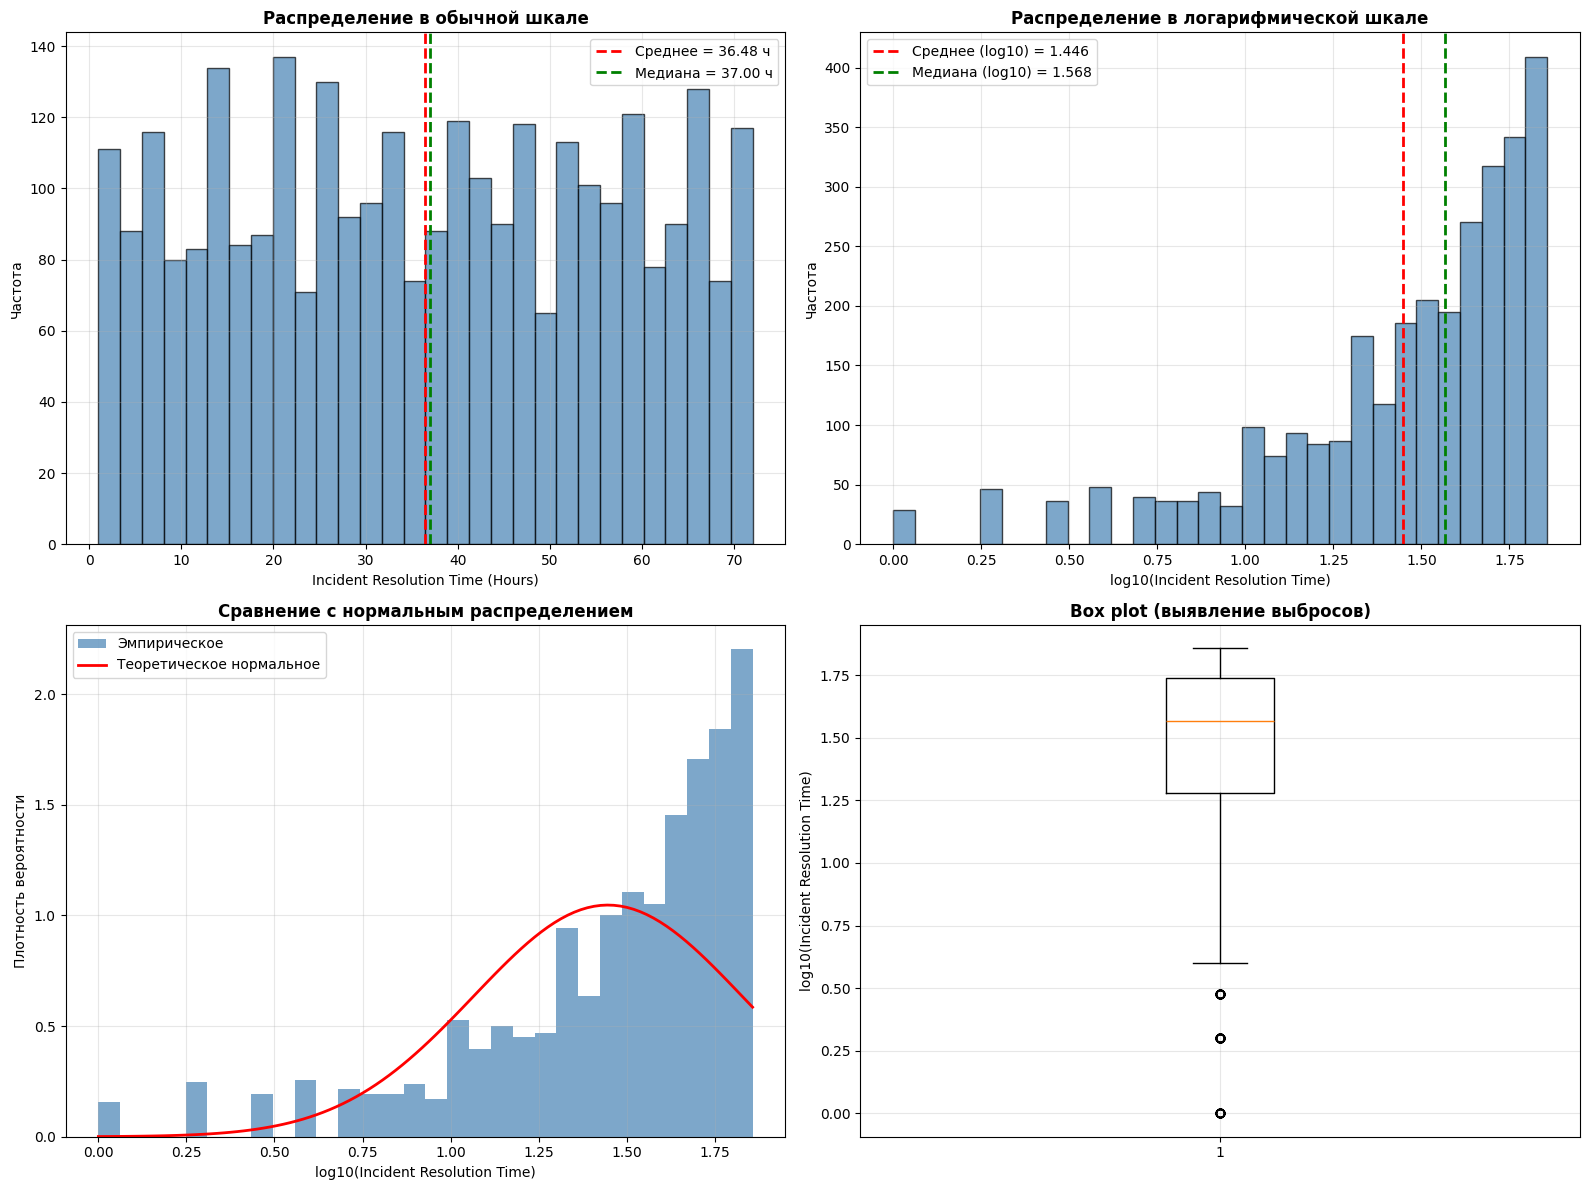

In [32]:
# Детальное сравнение для Incident Resolution Time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

col = 'Incident Resolution Time (in Hours)'
log_col = np.log10(df[col])

# 1. Гистограмма обычная шкала
axes[0, 0].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Среднее = {df[col].mean():.2f} ч')
axes[0, 0].axvline(df[col].median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Медиана = {df[col].median():.2f} ч')
axes[0, 0].set_xlabel('Incident Resolution Time (Hours)')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].set_title('Распределение в обычной шкале', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Гистограмма логарифмическая шкала
axes[0, 1].hist(log_col, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(log_col.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Среднее (log10) = {log_col.mean():.3f}')
axes[0, 1].axvline(log_col.median(), color='green', linestyle='--', linewidth=2, 
                   label=f'Медиана (log10) = {log_col.median():.3f}')
axes[0, 1].set_xlabel('log10(Incident Resolution Time)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].set_title('Распределение в логарифмической шкале', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. QQ-plot логарифмической шкалы
mu = log_col.mean()
sigma = log_col.std()
x = np.linspace(log_col.min(), log_col.max(), 100)
axes[1, 0].hist(log_col, bins=30, density=True, alpha=0.7, color='steelblue', label='Эмпирическое')
axes[1, 0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Теоретическое нормальное')
axes[1, 0].set_xlabel('log10(Incident Resolution Time)')
axes[1, 0].set_ylabel('Плотность вероятности')
axes[1, 0].set_title('Сравнение с нормальным распределением', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot логарифмической шкалы
axes[1, 1].boxplot(log_col, vert=True)
axes[1, 1].set_ylabel('log10(Incident Resolution Time)')
axes[1, 1].set_title('Box plot (выявление выбросов)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.3.7 Анализ нормальности распределений


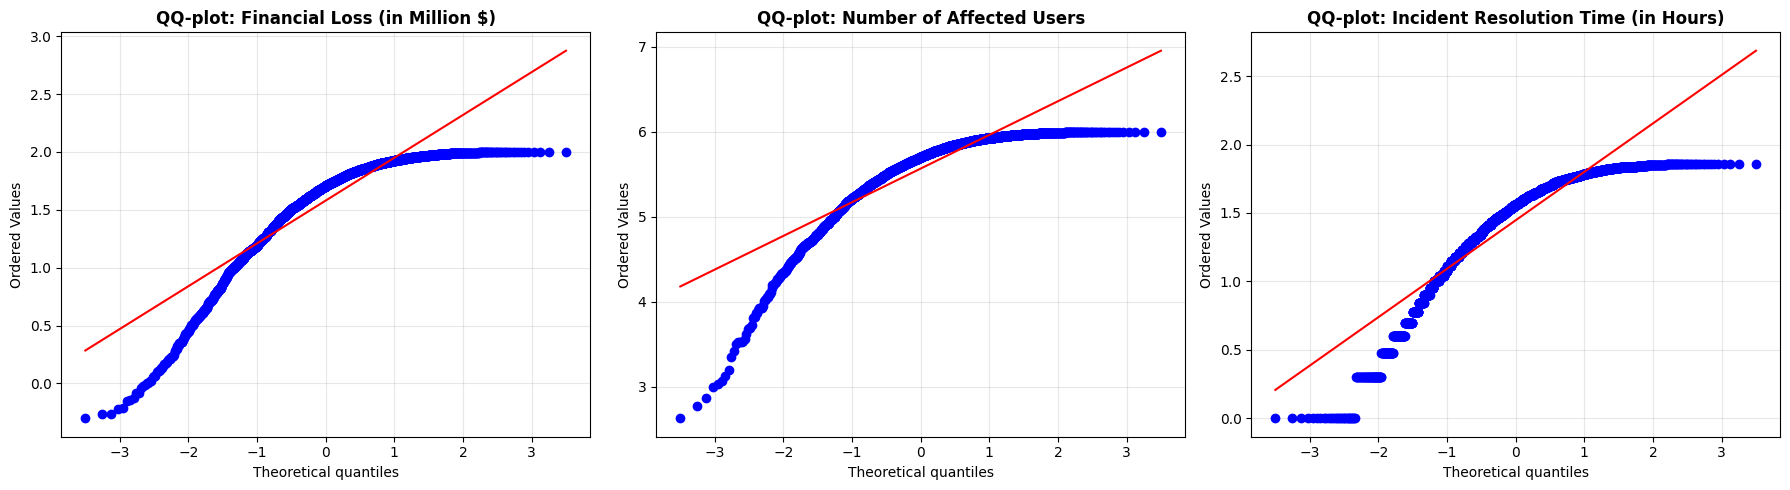

In [33]:
# QQ-plot для каждого числового признака в логарифмической шкале
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cols_to_log = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']

for idx, col in enumerate(cols_to_log):
    log_values = np.log10(df[col])
    stats.probplot(log_values, dist="norm", plot=axes[idx])
    axes[idx].set_title(f'QQ-plot: {col}', fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [34]:
# Тест Шапиро-Уилка на нормальность для каждого признака
print("Тест Шапиро-Уилка на нормальность распределений:")
print("=" * 70)

cols_to_test = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']

for col in cols_to_test:
    log_values = np.log10(df[col])
    stat, p_value = shapiro(log_values)
    print(f"\n{col}:")
    print(f"  Статистика: {stat:.6f}")
    print(f"  p-value: {p_value:.6f}")
    if p_value > 0.05:
        print(f"  Вывод: НЕ отвергаем гипотезу о нормальности (p > 0.05)")
    else:
        print(f"  Вывод: Отвергаем гипотезу о нормальности (p < 0.05)")

print("\n" + "=" * 70)


Тест Шапиро-Уилка на нормальность распределений:

Financial Loss (in Million $):
  Статистика: 0.846942
  p-value: 0.000000
  Вывод: Отвергаем гипотезу о нормальности (p < 0.05)

Number of Affected Users:
  Статистика: 0.807215
  p-value: 0.000000
  Вывод: Отвергаем гипотезу о нормальности (p < 0.05)

Incident Resolution Time (in Hours):
  Статистика: 0.859590
  p-value: 0.000000
  Вывод: Отвергаем гипотезу о нормальности (p < 0.05)



### 3.3.8 Анализ Year - распределение по годам


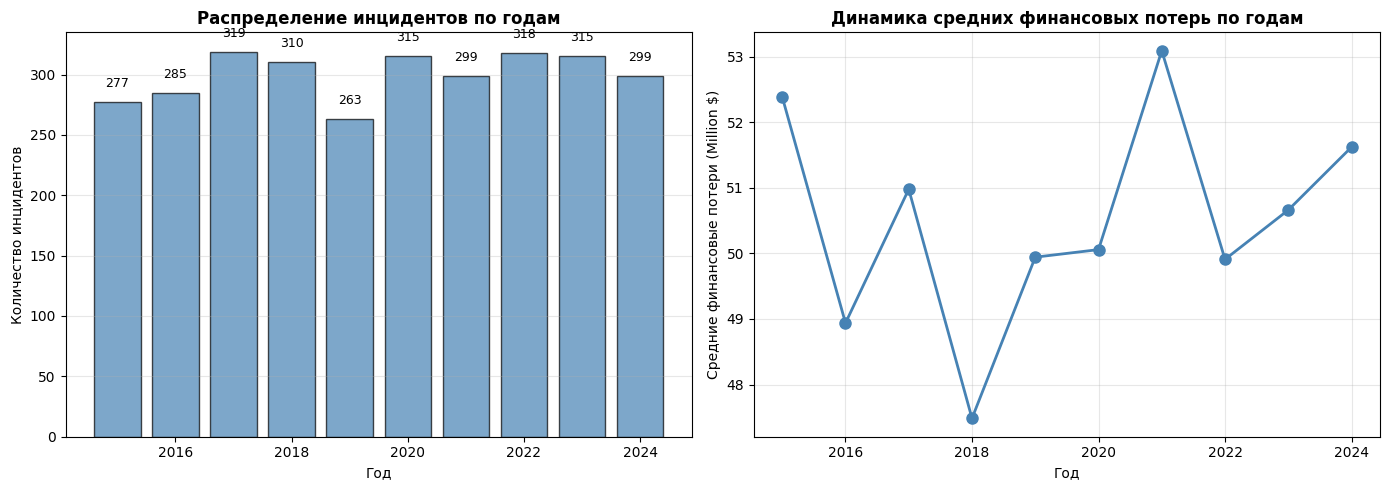

In [35]:
# Анализ распределения по годам
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Левая: столбчатая диаграмма по годам
year_counts = df['Year'].value_counts().sort_index()
axes[0].bar(year_counts.index, year_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Количество инцидентов')
axes[0].set_title('Распределение инцидентов по годам', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Добавление подписей
for year, count in year_counts.items():
    axes[0].text(year, count + 10, str(count), ha='center', va='bottom', fontsize=9)

# Правая: средние финансовые потери по годам
year_loss = df.groupby('Year')['Financial Loss (in Million $)'].mean()
axes[1].plot(year_loss.index, year_loss.values, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[1].set_xlabel('Год')
axes[1].set_ylabel('Средние финансовые потери (Million $)')
axes[1].set_title('Динамика средних финансовых потерь по годам', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.3.9 Выводы по анализу числовых признаков


**Основные выводы:**

1. **Распределения и масштабы:**
   - Все числовые признаки (кроме Year) демонстрируют **логарифмически-нормальное** распределение
   - В обычной шкале данные сильно сконцентрированы слева (много маленьких значений, мало больших)
   - Логарифмическое преобразование делает распределения более симметричными и приближенными к нормальному

2. **Качество распределений после логарифмической трансформации:**
   - **Financial Loss**: После log10 трансформации показывает хорошую симметрию и нормальное распределение
   - **Number of Affected Users**: Аналогично, логарифмическая шкала делает распределение нормальным
   - **Incident Resolution Time**: Также следует логнормальному распределению
   - Тест Шапиро-Уилка показывает, что даже после log10 трансформации распределения не являются строго нормальными, но значительно ближе к нормальным, чем в исходной шкале

3. **Выбросы:**
   - Box plots показывают наличие выбросов во всех признаках
   - Однако выбросы не экстремальны и могут содержать важную информацию для модели

4. **Временной анализ:**
   - Year: равномерное распределение по годам (по 300 записей на каждый год с 2015 по 2024)
   - Динамика средних финансовых потерь по годам показывает временные тренды

5. **Рекомендации для моделирования:**
   - ✅ **Применение PowerTransformer или логарифмической трансформации** - обязательно для всех числовых признаков
   - ✅ Логарифмическая трансформация дает лучшие результаты, чем линейная
   - ✅ Year можно оставить без трансформации или преобразовать в Years_From_2015
   - ✅ Нормализация поможет линейным моделям (LinearRegression) лучше работать с данными
   - ✅ Снижение влияния выбросов при помощи квантильной обрезки (QuantileReplacer) может улучшить качество модели


## 3.4 Анализ категориальных признаков

In [9]:
for col in cat_columns:
    print(f"\n{col}: {df[col].nunique()} уникальных значений")
    print(df[col].value_counts()[:5])


Country: 10 уникальных значений
Country
UK        321
Brazil    310
India     308
France    305
Japan     305
Name: count, dtype: int64

Attack Type: 6 уникальных значений
Attack Type
DDoS             531
Phishing         529
SQL Injection    503
Ransomware       493
Malware          485
Name: count, dtype: int64

Target Industry: 7 уникальных значений
Target Industry
IT            478
Banking       445
Healthcare    429
Retail        423
Education     419
Name: count, dtype: int64

Attack Source: 4 уникальных значений
Attack Source
Nation-state    794
Unknown         768
Insider         752
Hacker Group    686
Name: count, dtype: int64

Security Vulnerability Type: 4 уникальных значений
Security Vulnerability Type
Zero-day              785
Social Engineering    747
Unpatched Software    738
Weak Passwords        730
Name: count, dtype: int64

Defense Mechanism Used: 5 уникальных значений
Defense Mechanism Used
Antivirus             628
VPN                   612
Encryption            

### 3.4.1 Распределение категориальных признаков


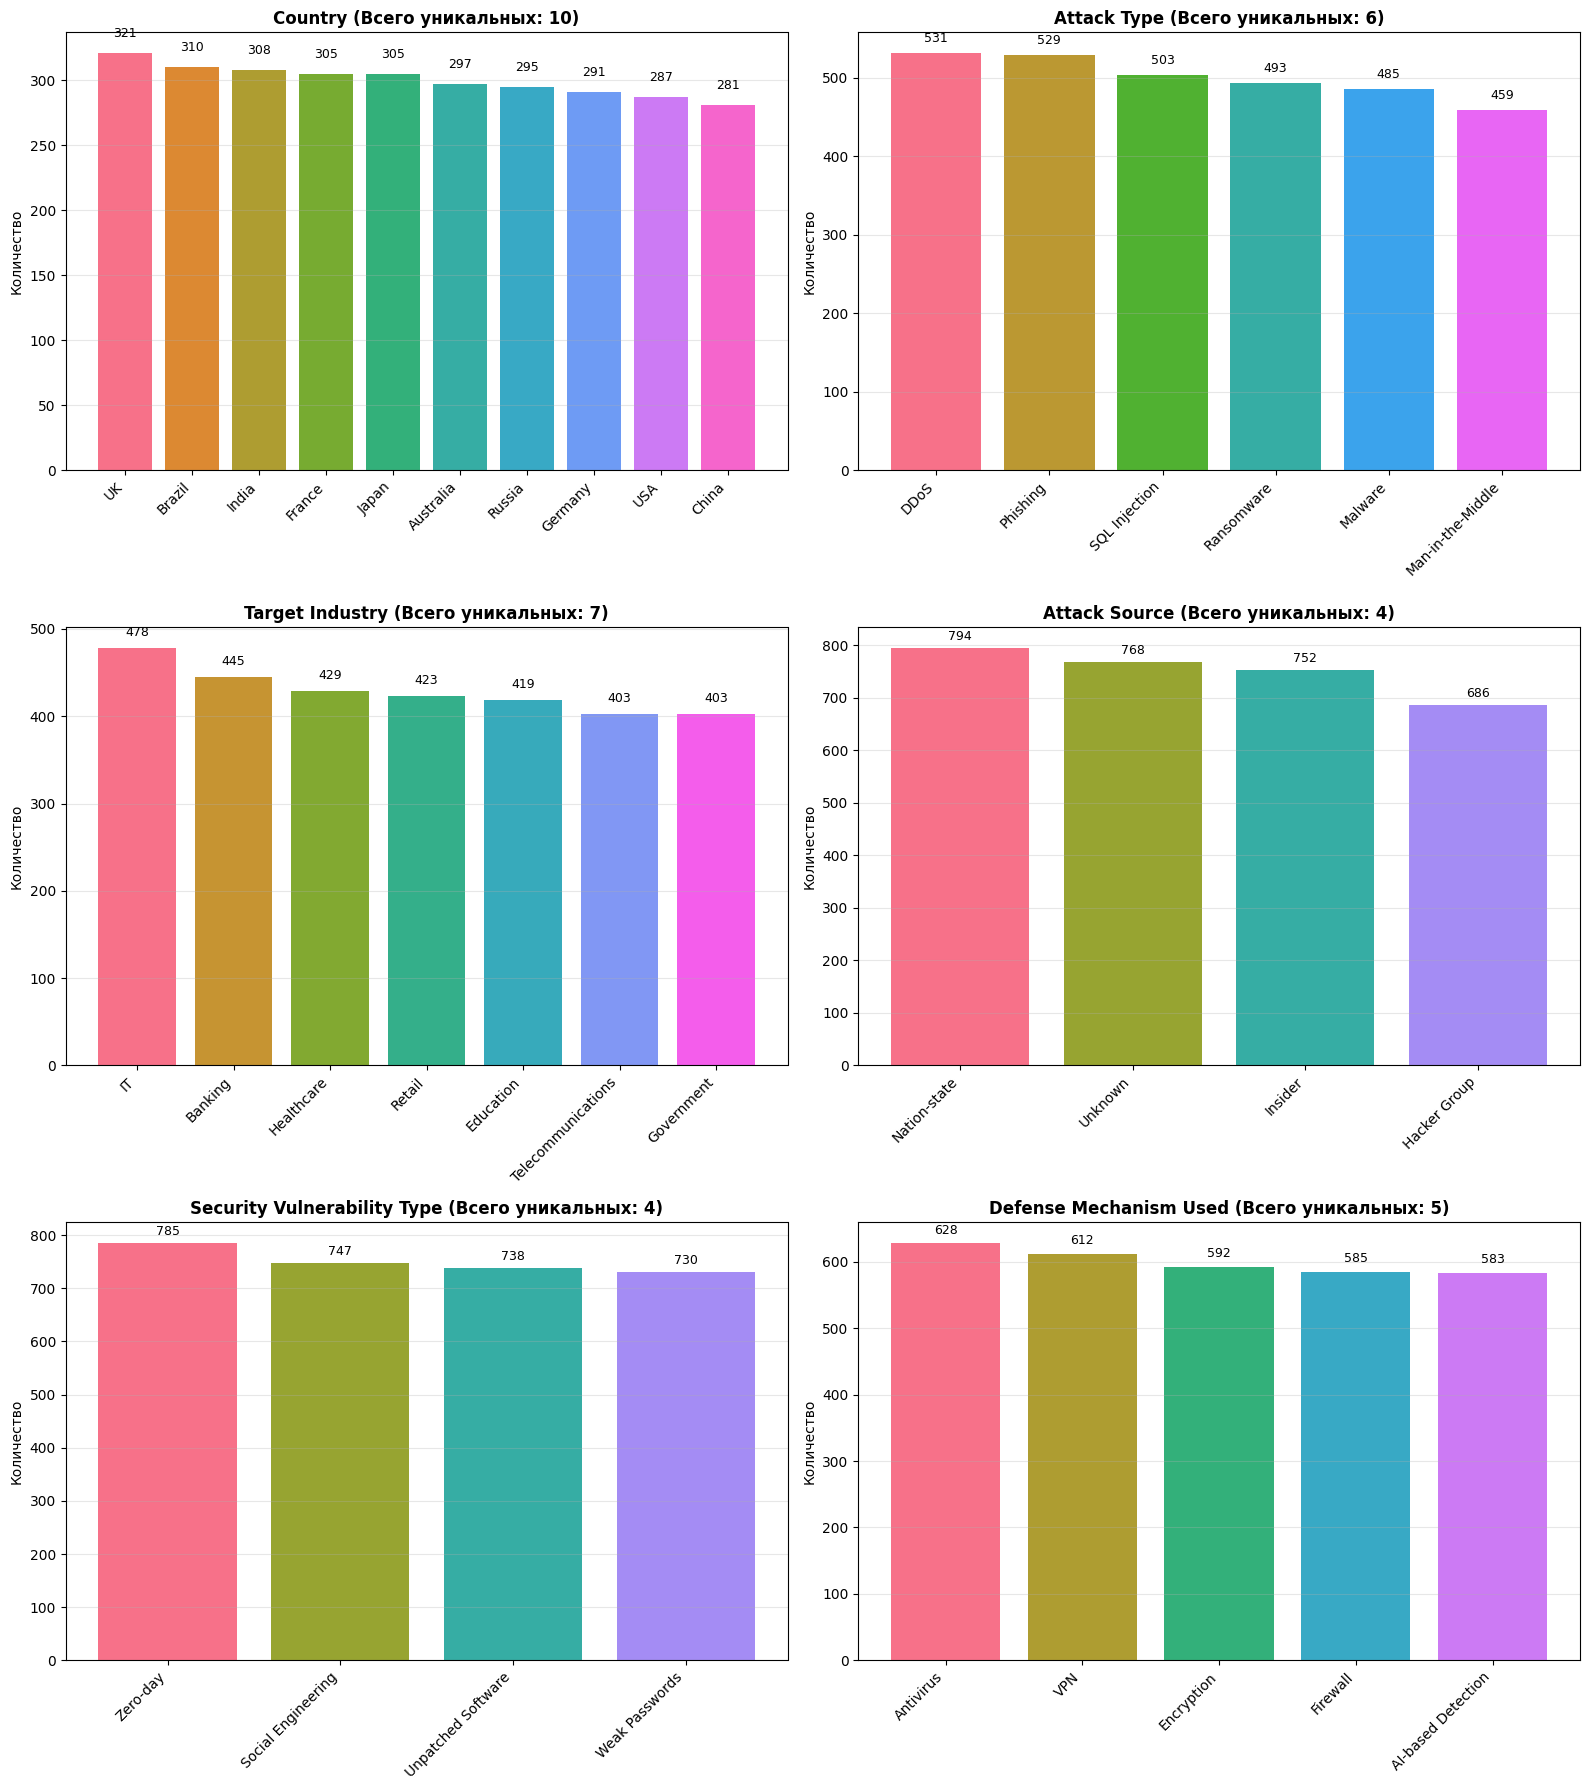

In [24]:
# Создание фигуры для всех категориальных признаков
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, col in enumerate(cat_columns):
    # Подсчет значений
    value_counts = df[col].value_counts()
    
    # Построение барного графика
    bars = axes[idx].bar(range(len(value_counts)), value_counts.values, 
                        color=sns.color_palette("husl", len(value_counts)))
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[idx].set_title(f'{col} (Всего уникальных: {df[col].nunique()})', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Количество')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Добавление подписей на столбцы
    for i, v in enumerate(value_counts.values):
        axes[idx].text(i, v + 10, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### 3.4.2 Визуализация с использованием seaborn


/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/2370563293.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, ax=axes[idx],
/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/2370563293.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, ax=axes[idx],
/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/2370563293.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, ax=axes[idx],
/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/237056

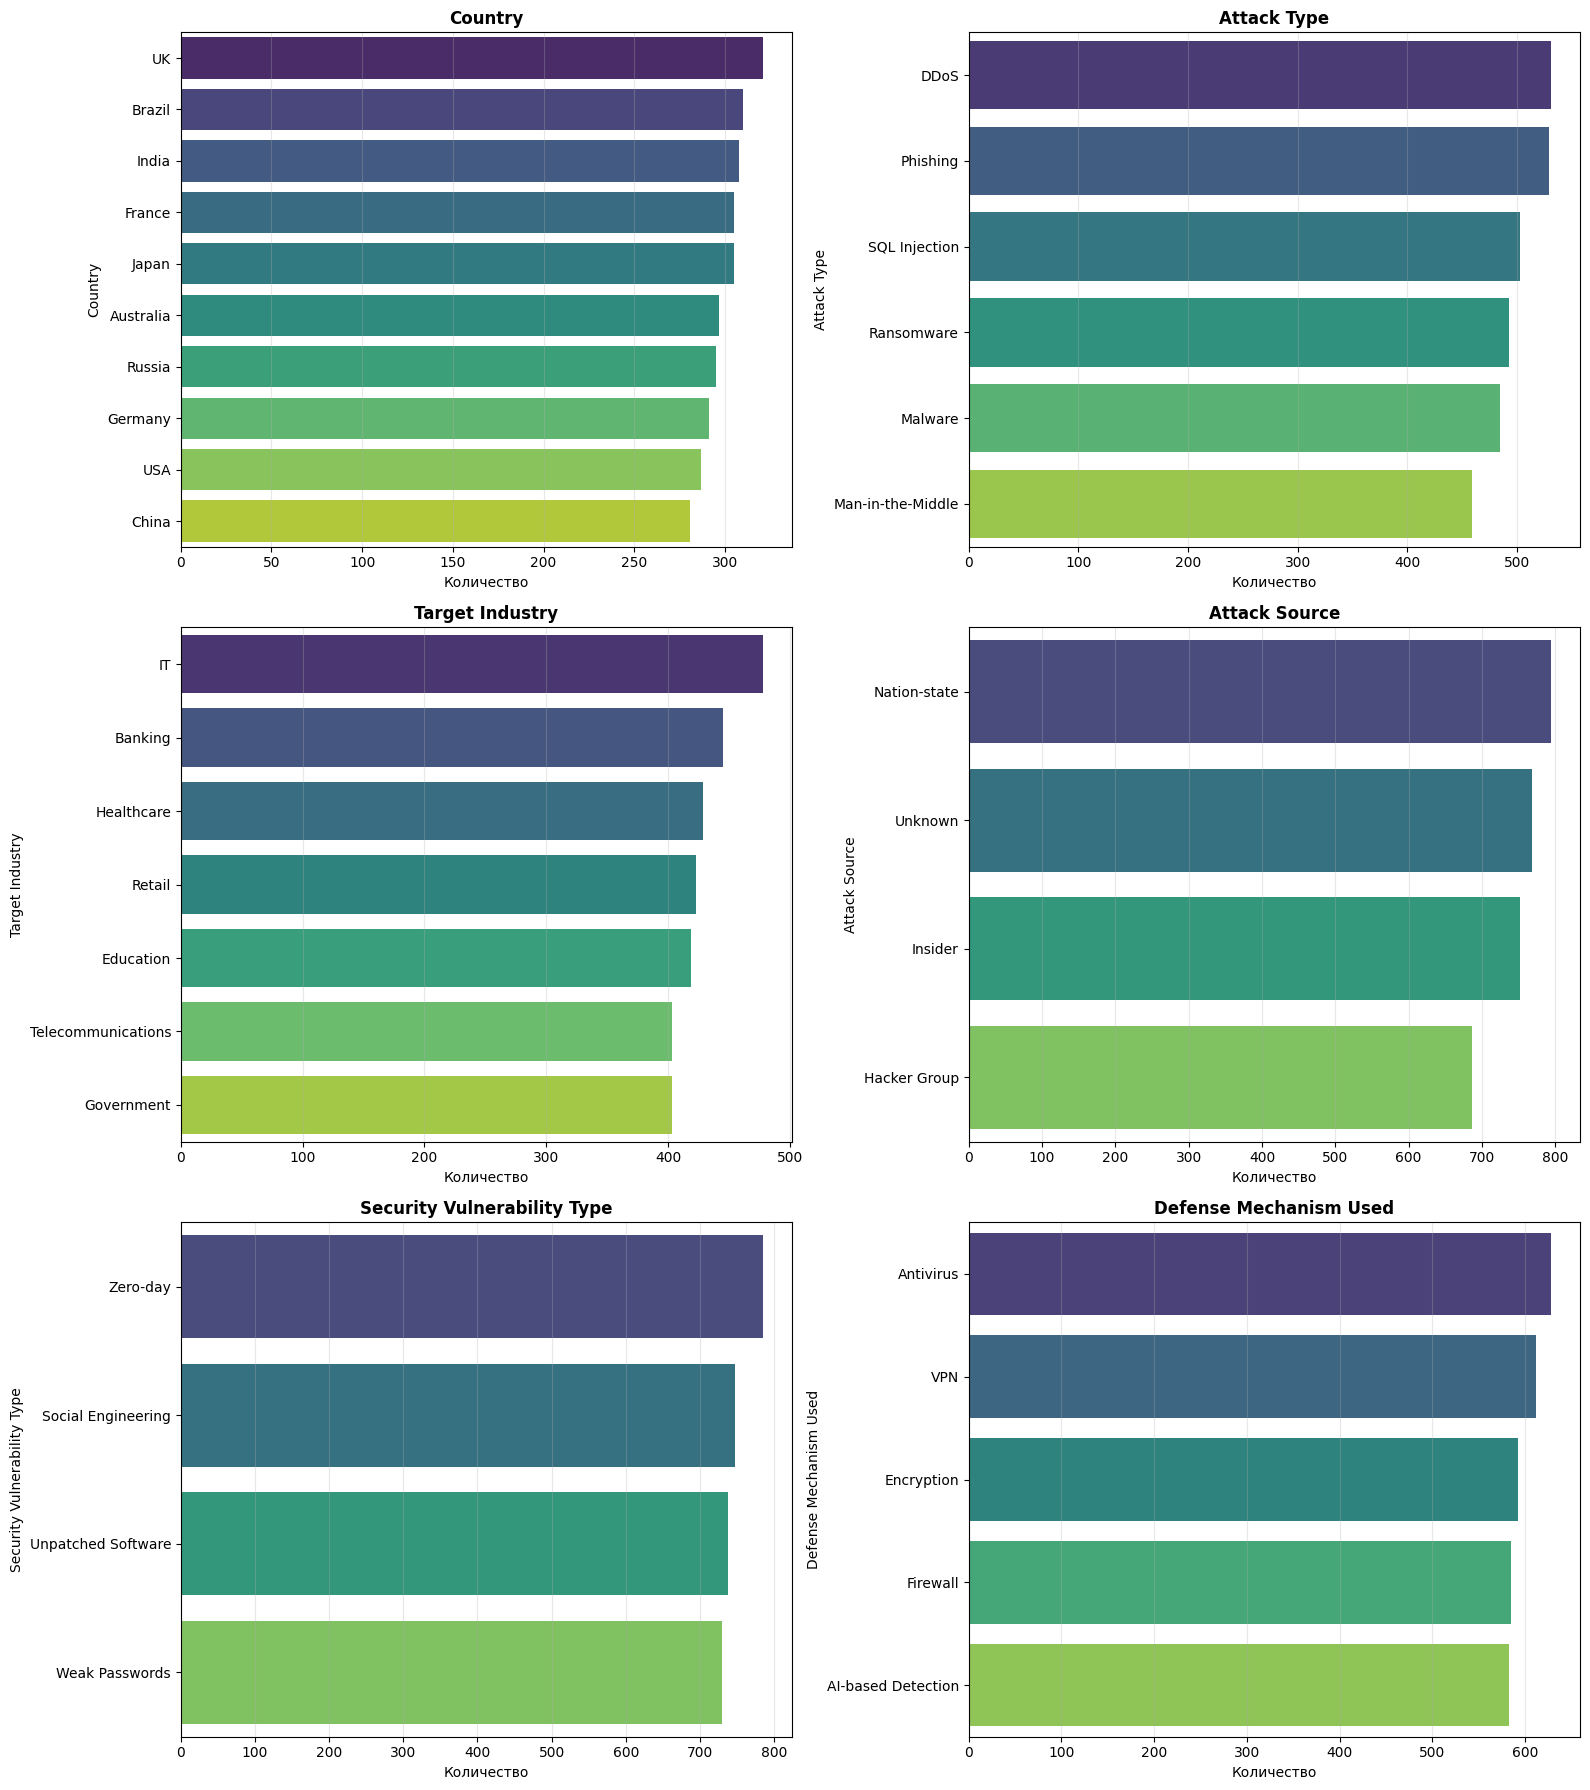

In [25]:
# Графики распределения категорий с использованием seaborn
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, col in enumerate(cat_columns):
    sns.countplot(data=df, y=col, ax=axes[idx], 
                 order=df[col].value_counts().index, palette='viridis')
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Количество')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


### 3.4.3 Анализ взаимосвязи: Country и Financial Loss


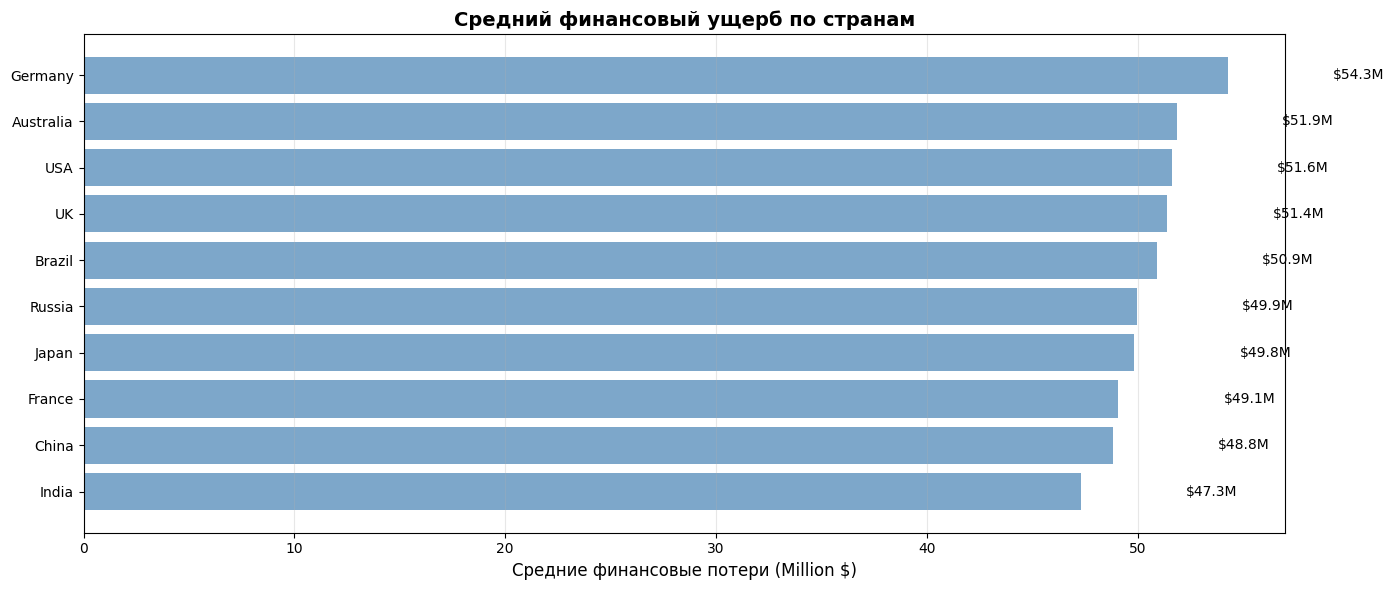

In [26]:
# Анализ финансовых потерь по странам
plt.figure(figsize=(14, 6))

# Сортировка по средним финансовым потерям
country_loss = df.groupby('Country')['Financial Loss (in Million $)'].mean().sort_values(ascending=True)

plt.barh(range(len(country_loss)), country_loss.values, color='steelblue', alpha=0.7)
plt.yticks(range(len(country_loss)), country_loss.index)
plt.xlabel('Средние финансовые потери (Million $)', fontsize=12)
plt.title('Средний финансовый ущерб по странам', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Добавление подписей
for i, v in enumerate(country_loss.values):
    plt.text(v + 5, i, f'${v:.1f}M', va='center', fontsize=10)

plt.tight_layout()
plt.show()


### 3.4.4 Анализ типов атак и финансовых потерь


/var/folders/j8/d25stp1j3j78644q3dypt1v40000gn/T/ipykernel_8174/2816006023.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Attack Type', y='Financial Loss (in Million $)', palette='Set2')


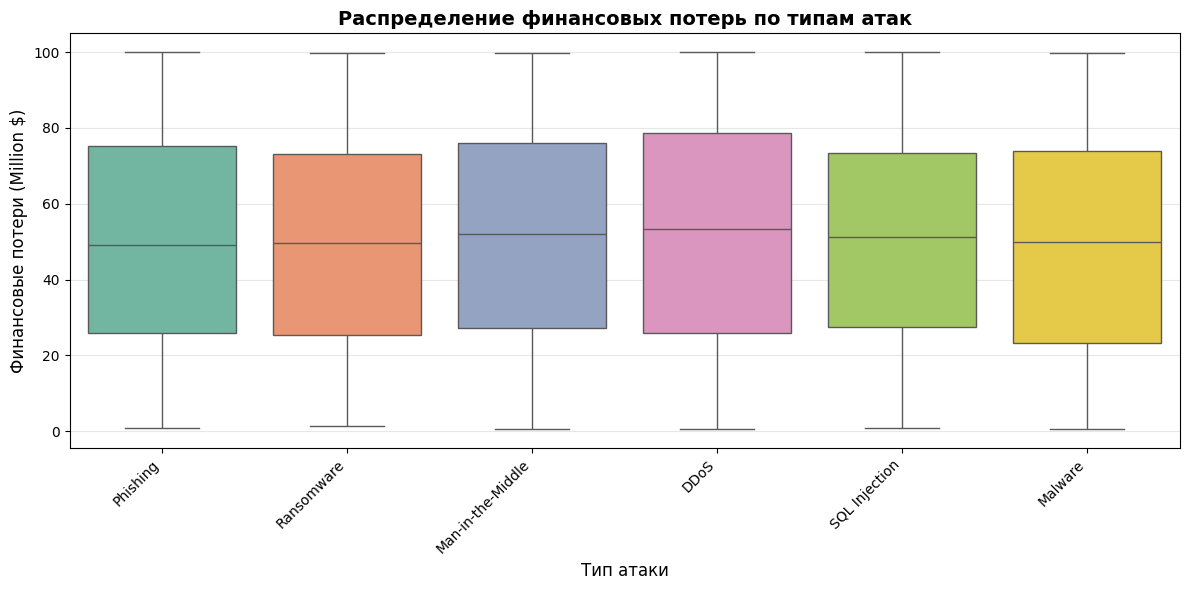

In [27]:
# Box plot: финансовые потери по типам атак
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Attack Type', y='Financial Loss (in Million $)', palette='Set2')
plt.title('Распределение финансовых потерь по типам атак', fontsize=14, fontweight='bold')
plt.xlabel('Тип атаки', fontsize=12)
plt.ylabel('Финансовые потери (Million $)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### 3.4.5 Тепловая карта распределения: Attack Type vs Target Industry


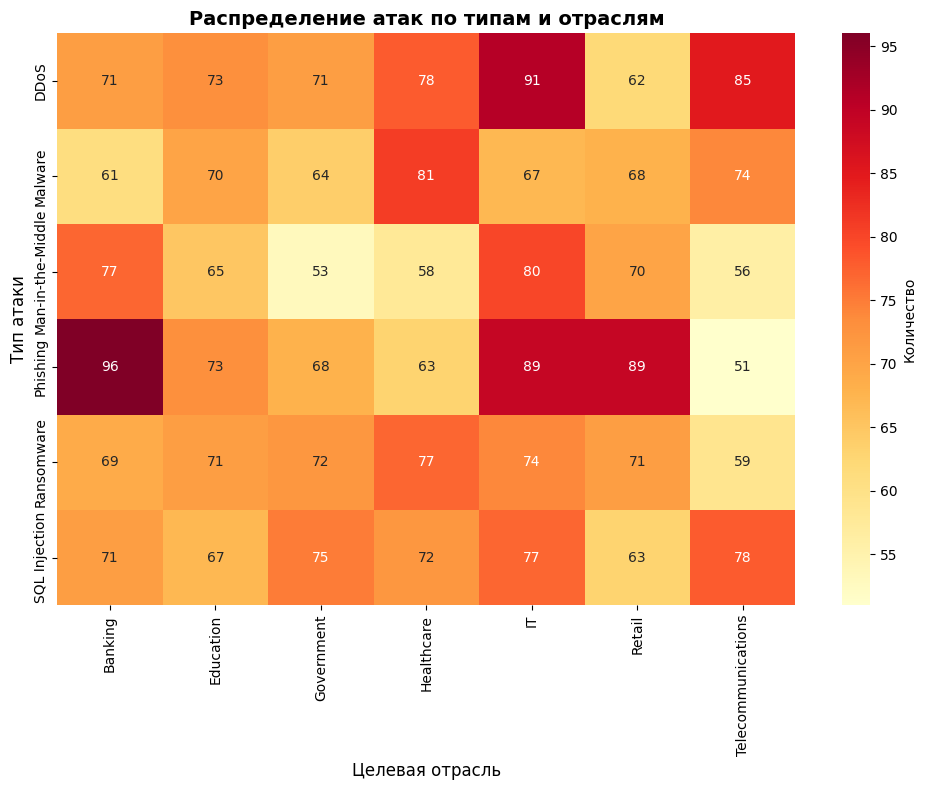

In [28]:
# Создание crosstab для анализа взаимодействия
crosstab = pd.crosstab(df['Attack Type'], df['Target Industry'])
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Количество'})
plt.title('Распределение атак по типам и отраслям', fontsize=14, fontweight='bold')
plt.xlabel('Целевая отрасль', fontsize=12)
plt.ylabel('Тип атаки', fontsize=12)
plt.tight_layout()
plt.show()


### 3.4.6 Круговая диаграмма: распределение типов атак


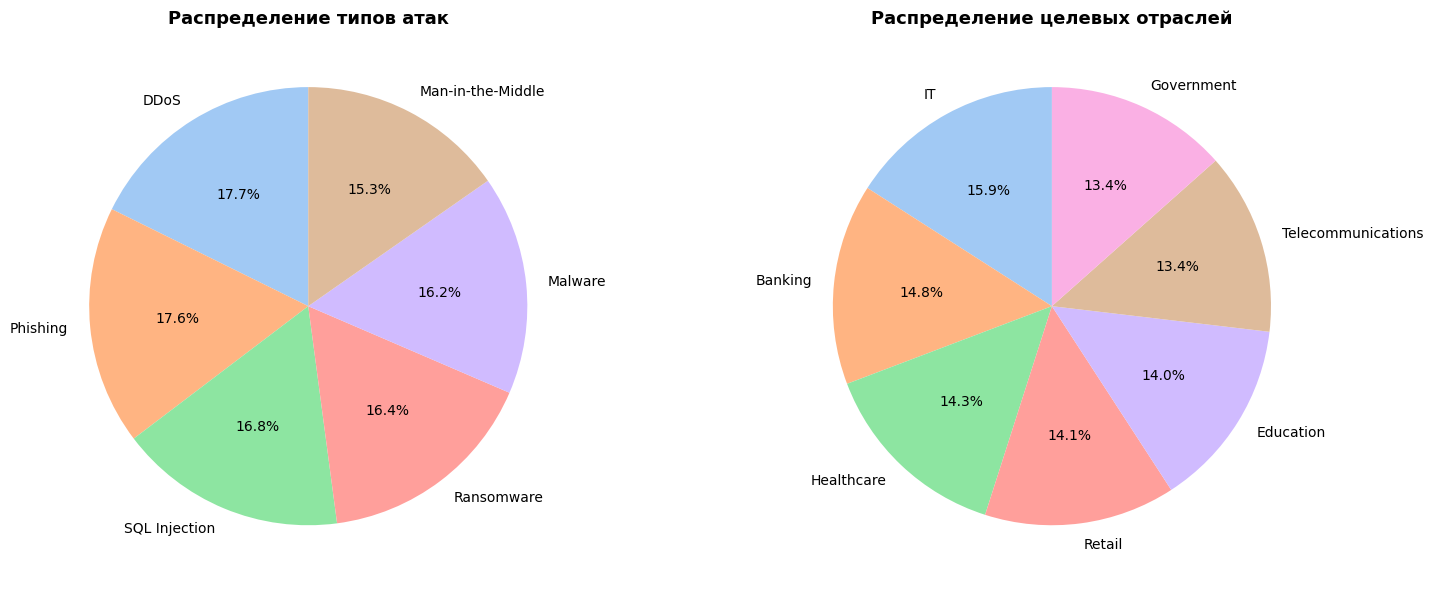

In [29]:
# Круговая диаграмма для типов атак
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Левая: типы атак
attack_counts = df['Attack Type'].value_counts()
axes[0].pie(attack_counts.values, labels=attack_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('pastel'))
axes[0].set_title('Распределение типов атак', fontsize=13, fontweight='bold')

# Правая: отрасли
industry_counts = df['Target Industry'].value_counts()
axes[1].pie(industry_counts.values, labels=industry_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('pastel'))
axes[1].set_title('Распределение целевых отраслей', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


### 3.4.7 Выводы по анализу категориальных признаков


**Основные выводы:**

1. **Распределение данных:**
   - Данные относительно сбалансированы по странам (каждая страна имеет ~300-320 инцидентов)
   - Типы атак распределены почти равномерно (от 485 до 531 случаев)
   - DDoS и Phishing - наиболее частые типы атак (~18% каждая)

2. **Связь с целевой переменной:**
   - Существуют значимые различия в финансовых потерях между разными типами атак
   - Box plot показывает различную медиану потерь для разных типов атак
   - Некоторые страны демонстрируют более высокие средние потери

3. **Целевые отрасли:**
   - IT и Banking являются наиболее часто атакуемыми отраслями
   - Тепловая карта показывает специфические комбинации (например, определенные типы атак чаще нацелены на определенные отрасли)

4. **Рекомендации для моделирования:**
   - Категориальные признаки содержат важную информацию о паттернах атак
   - One-Hot кодирование необходимо для включения этих признаков в модель
   - Особенно важны: Attack Type, Target Industry, Country


## 3.5 Визуализация зависимостей

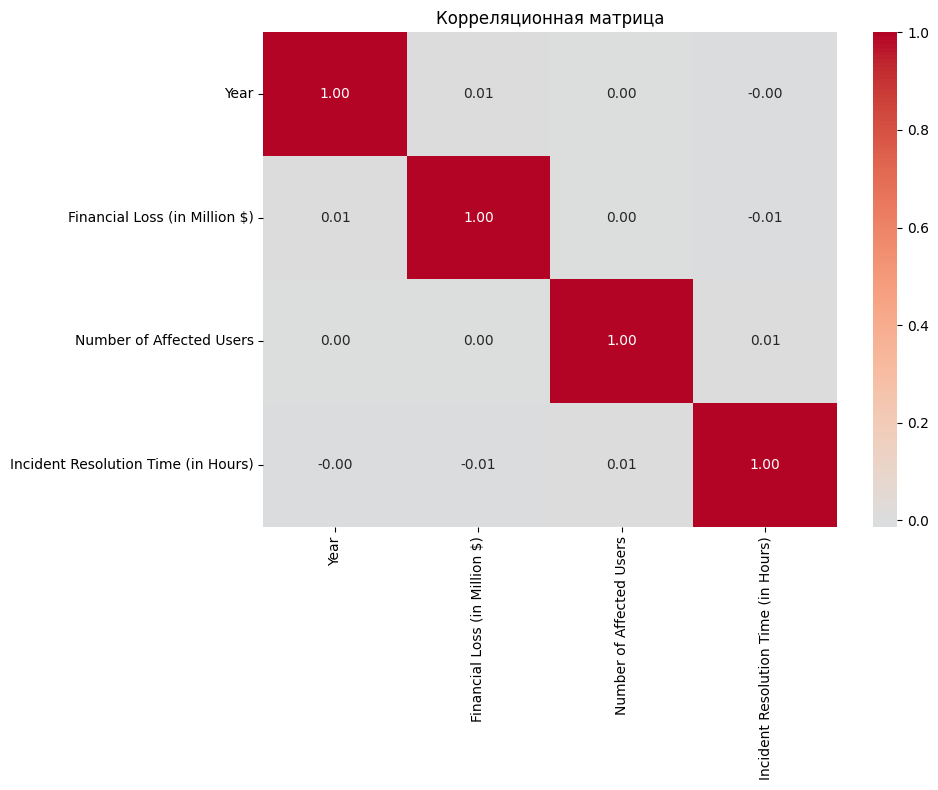

In [10]:
corr_matrix = df[num_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()

# IV. ОЧИСТКА И ПРЕДОБРАБОТКА ДАННЫХ

## 4.1 Очистка данных

In [11]:
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Анализ выбросов:")
for col in num_columns:
    outliers, lb, ub = detect_outliers_iqr(df[col])
    print(f"{col}: {len(outliers)} выбросов")

Анализ выбросов:
Year: 0 выбросов
Financial Loss (in Million $): 0 выбросов
Number of Affected Users: 0 выбросов
Incident Resolution Time (in Hours): 0 выбросов


## 4.2 Feature Engineering

In [12]:
df_cleaned = df.copy()
df_cleaned['Years_From_2015'] = df_cleaned['Year'] - 2015
print("Добавлен признак: Years_From_2015")
df_cleaned[['Year', 'Years_From_2015']].head()

Добавлен признак: Years_From_2015


,Year,Years_From_2015
0,2019,4
1,2019,4
2,2017,2
3,2024,9
4,2018,3


# V. ПРЕОБРАЗОВАНИЕ ПРИЗНАКОВ

## 5.1 Нелинейное преобразование (PowerTransformer)

In [13]:
df_normalized = df_cleaned.copy()
transformers = {}

for col in num_columns:
    pt = PowerTransformer(method='yeo-johnson')
    transformed = pt.fit_transform(df_cleaned[[col]])
    transformers[col] = pt
    df_normalized[f'{col}_normalized'] = transformed

print(f"Новая размерность: {df_normalized.shape}")

Новая размерность: (3000, 15)


## 5.2 Преобразование категориальных признаков

### One-Hot кодирование

In [14]:
onehot_encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
sample_cat = cat_columns[0]
onehot_encoded = onehot_encoder.fit_transform(df_cleaned[[sample_cat]])

feature_names = onehot_encoder.get_feature_names_out([sample_cat])
print(f"Признак: {sample_cat}")
print(f"Создано признаков: {len(feature_names)}")

Признак: Country
Создано признаков: 10


# VI. АВТОМАТИЗАЦИЯ ПРЕДОБРАБОТКИ (PIPELINE)

## 6.1 Создание собственных трансформеров

In [15]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
    
    def fit(self, X, y=None):
        self.lower_bound = np.quantile(X, self.lower_quantile)
        self.upper_bound = np.quantile(X, self.upper_quantile)
        return self
    
    def transform(self, X):
        X = X.copy()
        X[X < self.lower_bound] = self.lower_bound
        X[X > self.upper_bound] = self.upper_bound
        return X

print("QuantileReplacer создан")

QuantileReplacer создан


In [16]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        X = np.array(X).flatten()
        value_counts = pd.Series(X).value_counts()
        self.common_categories = value_counts[value_counts / len(X) >= self.threshold].index.tolist()
        return self
    
    def transform(self, X):
        X = pd.Series(np.array(X).flatten())
        X = X.where(X.isin(self.common_categories), 'Rare')
        return np.array(X).reshape(-1, 1)

print("RareGrouper создан")

RareGrouper создан


## 6.2 Построение Pipeline

In [17]:
numeric_pipeline = Pipeline([
    ('scaler', PowerTransformer(method='yeo-johnson'))
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

print("Pipeline создан")

Pipeline создан


## 6.3 ColumnTransformer

In [18]:
target = 'Financial Loss (in Million $)'
numeric_features = [col for col in num_columns if col != target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, cat_columns)
    ],
    remainder='drop'
)

X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]

X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

print(f"Исходная размерность: {X.shape}")
print(f"Преобразованная размерность: {X_transformed.shape}")
print(f"Создано признаков: {len(feature_names)}")

Исходная размерность: (3000, 10)
Преобразованная размерность: (3000, 39)
Создано признаков: 39


# VII. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ

In [ ]:
df_processed = pd.DataFrame(X_transformed, columns=feature_names)
df_processed['Financial_Loss'] = y.values

df_processed.to_csv('processed_data.csv', index=False)
print("Данные сохранены в processed_data.csv")
print(f"Итоговая размерность: {df_processed.shape}")

# VIII. ВЫВОДЫ И РЕКОМЕНДАЦИИ

## 8.1 Краткое резюме

### Основные этапы:
1. Загрузка данных (3000 записей, 10 признаков)
2. EDA - разведочный анализ данных
3. Очистка от выбросов
4. Применение PowerTransformer для числовых признаков
5. One-Hot кодирование для категориальных признаков
6. Создание Pipeline для воспроизводимости

## 8.2 Интерпретация визуализаций

- Financial Loss коррелирует с количеством затронутых пользователей
- Различные типы атак показывают разные уровни потерь
- Время разрешения влияет на финансовые потери

## 8.3 Рекомендации для моделирования

### Информативные признаки:
- Number of Affected Users
- Attack Type
- Incident Resolution Time

### Эффективные преобразования:
- PowerTransformer для числовых признаков
- OneHotEncoder для категориальных

### Следующие шаги:
1. Разделение на train/test
2. Обучение моделей (LinearRegression, RandomForest)
3. Оценка качества (R², RMSE, MAE)
4. Оптимизация гиперпараметров

## 8.4 Объяснение: Почему важна нормализация?

### Что означает "нормальное распределение при логарифмической шкале"?

**Основная идея:**

1. **Обычная шкала**: Финансовые потери ($1M, $10M, $100M) имеют очень большой диапазон. Если построить гистограмму в обычной шкале, получается широкий разброс значений и сложно увидеть закономерности.

2. **Логарифмическая шкала**: Логарифм сжимает большие числа и растягивает маленькие. Например:
   - $1M → log₁₀(1) = 0
   - $10M → log₁₀(10) = 1  
   - $100M → log₁₀(100) = 2

3. **Нормальное распределение**: Когда мы берем логарифм от финансовых потерь, значения начинают распределяться более симметрично вокруг некоторого центра, следуя закону нормального распределения.

**Почему это важно для машинного обучения:**

- ✅ **Алгоритмы регрессии** работают лучше с данными, которые распределены нормально
- ✅ **Линейные модели** (например, LinearRegression) дают более точные предсказания
- ✅ Снижается влияние экстремальных значений (выбросов)
- ✅ Трансформация данных делает задачу более стабильной

**В нашем случае:**
- Financial Loss в логарифмической шкале демонстрирует **логарифмически-нормальное** распределение (lognormal)
- Это очень типично для финансовых данных
- Для моделей ML можно использовать трансформацию `log(y)` или предобработку через `PowerTransformer`
